In [2]:
%%javascript

window.load_remote_theme = false
var theme_url = "https://drostehk.github.io/ipynb-theme/";
var asset_url = 'https://raw.githubusercontent.com/tijptjik/DS_assets/master/';

window.load_local_theme = function(){
    var hostname = document.location.hostname
    return ((hostname == "localhost" || hostname == '127.0.0.1') && !load_remote_theme)
}

var url = load_local_theme() ? document.location.origin + "/files/theme/custom.js" : theme_url + 'custom.js'

$.getScript(url)

<IPython.core.display.Javascript object>

# Data Wrangling

> “Show me your code and conceal your data structures, and I shall continue to be mystified. Show me your data structures, and I won’t usually need your code; it’ll be obvious.” 

<footer>**Eric Raymond**, in The Cathedral and the Bazaar, 1997</footer>

![](http://imgs.xkcd.com/comics/exploits_of_a_mom.png)


![break](assets/agenda.png)

## Agenda

1. Data Structures : Flat or Go Deep?
1. Getting freaky with `pandas`
1. Abstracting the query with `blaze`

## Data Structures

To  explore data modeling techniques, we have to start with a more or less systematic view of NoSQL data models that preferably reveals trends and interconnections. The following figure depicts imaginary “evolution” of the major NoSQL system families, namely, Key-Value stores, BigTable-style databases, Document databases, Full Text Search Engines, and Graph databases:

![](https://highlyscalable.files.wordpress.com/2012/02/overview2.png)

## Data Serialisation Formats

When saving or communicating some kind of information, we often use serialization. Serialization takes a Python object and converts it into a string of bytes and vice versa. For example, if you have an object representing information about a user and need to send it over the network, it has to be serialized into a set of bytes that can be pushed over a socket. Then, at the other end, the receiver has to unserialize the object, converting it back into something that Python (or another language) can understand.

### CSV

The basic problem is this: CSVs have inherent schemas. In fact, most of the CSVs that I work with are dumps from a database. While the database can maintain schema information alongside the data, the scheme is lost when serializing to disk. Worse, if the dump is denormalized (a join of two tables), then the relationships are also lost, making it harder to extract entities. Although a header row can give us the names of the fields in the file, it won't give us the type, and there is nothing structural about the serialization format (like there is with JSON) that we can infer the type from.

In [15]:
DATA_DIR = '../data/'

#### But we've got pandas?

In [17]:
import pandas as pd

data = pd.read_csv(DATA_DIR + 'funding.csv')
print data.head(5)

     permalink      company  numEmps category        city state fundedDate  \
0     lifelock     LifeLock      NaN      web       Tempe    AZ   1-May-07   
1     lifelock     LifeLock      NaN      web       Tempe    AZ   1-Oct-06   
2     lifelock     LifeLock      NaN      web       Tempe    AZ   1-Jan-08   
3  mycityfaces  MyCityFaces        7      web  Scottsdale    AZ   1-Jan-08   
4     flypaper     Flypaper      NaN      web     Phoenix    AZ   1-Feb-08   

   raisedAmt raisedCurrency round  
0    6850000            USD     b  
1    6000000            USD     a  
2   25000000            USD     c  
3      50000            USD  seed  
4    3000000            USD     a  


The utilities for analysis that `Pandas` gives you, especially `DataFrames`, are extremely useful, and there is obviously a 1:1 relationship between DataFrames and CSV files. We routinely use Pandas for data analyses, quick insights, and even data wrangling of smaller files.

The problem is that Pandas is not meant for production-level ingestion or wrangling systems. It is meant for data analysis that can happen completely in memory. As such, when you run this line of code, the entirety of the CSV file is loaded into memory. Likewise, Numpy arrays are also immutable data types that are completely loaded into memory. You've just lost your memory efficiency, especially for larger data sets.

And while this may be fine on your laptop, keep in mind that if you're writing data pipeline code, it will probably be run more routinely on a virtual cloud server such as Rackspace, AWS, or Google App Engine. Since you have a budget, it will also probably be running on small or micro servers that might have 1 GB of memory, if you're lucky. You don't want to blow it away!

#### Built-in CSV

In [12]:
import csv


def read_funding_data(path):
    with open(path, 'rU') as data:
        reader = csv.DictReader(data)
        for row in reader:
            yield row


for idx, row in enumerate(read_funding_data(DATA_DIR + 'funding.csv')):
    if idx > 10: break
    print "%(company)s (%(numEmps)s employees) raised %(raisedAmt)s on %(fundedDate)s" % row

LifeLock ( employees) raised 6850000 on 1-May-07
LifeLock ( employees) raised 6000000 on 1-Oct-06
LifeLock ( employees) raised 25000000 on 1-Jan-08
MyCityFaces (7 employees) raised 50000 on 1-Jan-08
Flypaper ( employees) raised 3000000 on 1-Feb-08
Infusionsoft (105 employees) raised 9000000 on 1-Oct-07
gAuto (4 employees) raised 250000 on 1-Jan-08
ChosenList.com (5 employees) raised 140000 on 1-Oct-06
ChosenList.com (5 employees) raised 233750 on 25-Jan-08
Digg (60 employees) raised 8500000 on 1-Dec-06
Digg (60 employees) raised 2800000 on 1-Oct-05


A couple of key points with the code above:

* Always wrap the `CSV` reader in a function that returns a generator (via the yield statement).
*  Open the file in universal newline mode with 'rU' for backwards compatibility.
* Use context managers with [callable] as [name] to ensure that the handle to the file is closed automatically.
* Use the `csv.DictReader` class only when headers are present, otherwise just use `csv.reader`. (You can pass a list of fieldnames, but you'll see its better just to use a namedtuple as we discuss below).

In [14]:
data = read_funding_data(DATA_DIR + 'funding.csv')
print repr(data)

<generator object read_funding_data at 0x7fd2466c1f50>


You'll see that the function "returns" a generator, thanks to the yield statement in the function definition. This means, among other things, that the data is evaluated lazily. The file is not opened, read, or parsed until you need it. 

### XML

XML is a widely used format for data exchange, because it gives good opportunities to keep the structure in the data and the way files are built on and allows developers to write parts of the documentation in with the data without interfering with the reading of them. This is pretty easy in Python as well. You will need the MiniDom library. It is also preinstalled.

In [22]:
x ="""<data>
    <items>
        <item name="item1"></item>
        <item name="item2"></item>
        <item name="item3"></item>
        <item name="item4"></item>
    </items>
</data>
"""

XML is a tree-like structure, while a Pandas DataFrame is a 2D table-like structure. So there is no automatic way to convert between the two. You have to understand the XML structure and know how you want to map its data onto a 2D table. Thus, every XML-to-DataFrame problem is different.

In [23]:
x

'<data>\n    <items>\n        <item name="item1"></item>\n        <item name="item2"></item>\n        <item name="item3"></item>\n        <item name="item4"></item>\n    </items>\n</data>\n'

In [29]:
from xml.dom import minidom

xmldoc = minidom.parseString(x)
itemlist = xmldoc.getElementsByTagName('item')

print itemlist

[<DOM Element: item at 0x7fd235dcecf8>, <DOM Element: item at 0x7fd235dce560>, <DOM Element: item at 0x7fd235dceea8>, <DOM Element: item at 0x7fd235d7f1b8>]


In [31]:
print(len(itemlist))

4


In [32]:
print(itemlist[0].attributes['name'].value)

item1


In [33]:
for s in itemlist:
    print(s.attributes['name'].value)

item1
item2
item3
item4


For simple analysis, however, we just want a rectangular data-frame with columns and rows and we need to flatten all that structure. The following code does a very simple job of converting an XML file into a Pandas data-frame. It recursively parses every branch in the file creating new columns and storing their value when information is found. It stores not just raw text as variables in the new dataset, but also all of the attributes stored in tags as well.

In [19]:
from bs4 import BeautifulSoup
import pandas as pd


def xml2df(xml_doc):
    f = open(xml_doc, 'r')
    soup = BeautifulSoup(f)
    name_list=[]
    text_list=[]
    attr_list=[]

    def recurs(soup):
        try:
            for j in soup.contents:
                try:
                    #print j.name
                    if j.name!=None:
                        name_list.append(j.name)
                except:
                    pass
                try:
                    #print j.text
                    if j.name!=None:
                        #print j.string
                        text_list.append(j.string)
                except:
                    pass
                try:
                    #print j.attrs
                    if j.name!=None:
                        attr_list.append(j.attrs)
                except:
                    pass
                recurs(j)
        except:
            pass
    recurs(soup)
    attr_names_list = [q.keys() for q in attr_list]
    attr_values_list = [q.values() for q in attr_list]
    columns = hstack((hstack(name_list),
                      hstack(attr_names_list)) )
    data = hstack((hstack(text_list),
                   hstack(attr_values_list)) )
    df = pd.DataFrame(data=matrix(data.T), columns=columns )
    return df

### JSON

JSON is a simple file format that is very easy for any programming language to read. Its simplicity means that it is generally easier for computers to process than others, such as XML. Working with JSON in Python is almost the same such as working with a Python dictionary. You will need the JSON library, but it is preinstalled to every Python 2.6 and after.

```json
{
    "glossary": {
        "title": "example glossary",
		"GlossDiv": {
            "title": "S",
			"GlossList": {
                "GlossEntry": {
                    "ID": "SGML",
					"SortAs": "SGML",
					"GlossTerm": "Standard Generalized Markup Language",
					"Acronym": "SGML",
					"Abbrev": "ISO 8879:1986",
					"GlossDef": {
                        "para": "A meta-markup language, used to create markup languages such as DocBook.",
						"GlossSeeAlso": ["GML", "XML"]
                    },
					"GlossSee": "markup"
                }
            }
        }
    }
}
```


which is the same as the `XML`

```xml
<!DOCTYPE glossary PUBLIC "-//OASIS//DTD DocBook V3.1//EN">
 <glossary><title>example glossary</title>
  <GlossDiv><title>S</title>
   <GlossList>
    <GlossEntry ID="SGML" SortAs="SGML">
     <GlossTerm>Standard Generalized Markup Language</GlossTerm>
     <Acronym>SGML</Acronym>
     <Abbrev>ISO 8879:1986</Abbrev>
     <GlossDef>
      <para>A meta-markup language, used to create markup
languages such as DocBook.</para>
      <GlossSeeAlso OtherTerm="GML">
      <GlossSeeAlso OtherTerm="XML">
     </GlossDef>
     <GlossSee OtherTerm="markup">
    </GlossEntry>
   </GlossList>
  </GlossDiv>
 </glossary>
```

We'll be working with JSON later on in today's class.

### YAML

YAML is a recursive acronym that stands for “YAML Ain’t Markup Language”. It is a serialization format, but it is also (easily) human readable, meaning that it can be used as a configuration language

In [52]:
import yaml
yaml.load("""
# YAML
name: Jesse
""")

{'name': 'Jesse'}

This is a simple example. Line 1 of the YAML file, or document, is a simple comment. Note that there is a space character right before that # sign. The next line is a simple key value pair which, after being parsed, gets returned to us in a Python dictionary. Simple as pie!

A simple name-value pair is easy to do. Here is a document with some additional structures and details to try:

In [53]:
yaml.load("""
# YAML
object:
    attributes:
        - attr1
        - attr2
        - attr3
    methods: [ getter, setter ]
""")

{'object': {'attributes': ['attr1', 'attr2', 'attr3'],
  'methods': ['getter', 'setter']}}

Here, we have defined a top-level entity named "object". This object has two block mappings related to it, ''attributes'' and ''methods''. The ''attributes'' mapping uses the more verbose YAML syntax for a list, in this case:

```bash
attributes:
    - attr1
    - attr2
    - attr3
```

For an extension treatmeent of YAML in Python see this [blogpost](http://jessenoller.com/blog/2009/04/13/yaml-aint-markup-language-completely-different)

## Dealing with APIs

Set your password for this session! 

In [14]:
import getpass
githubpassword = getpass.getpass()

········


In [20]:
import requests
from getpass import getpass
import json

username = 'tijptjik' # Your GitHub username
password = githubpassword # Your GitHub password

# Note that credentials will be transmitted over a secure SSL connection
url = 'https://api.github.com/authorizations'
note = 'Data Wrangling with GitHub'
post_data = {'scopes':['repo'],'note': note }

response = requests.post(
    url,
    auth = (username, password),
    data = json.dumps(post_data),
    )   

print "API response:", response.text
print
print "Your OAuth token is", response.json()['token']

# Go to https://github.com/settings/applications to revoke this token

API response: {"id":19736938,"url":"https://api.github.com/authorizations/19736938","app":{"name":"Data Wrangling with GitHub (API)","url":"https://developer.github.com/v3/oauth_authorizations/","client_id":"00000000000000000000"},"token":"6f58a0577a6c5848be56ad43b8e65d2cb4e93f17","hashed_token":"c38ae3d08f0a338bc4c6a9ee23f5946ffcc4e75563172eaee38e469a97f4cc42","token_last_eight":"b4e93f17","note":"Data Wrangling with GitHub","note_url":null,"created_at":"2015-07-03T18:23:17Z","updated_at":"2015-07-03T18:23:17Z","scopes":["repo"],"fingerprint":null}

Your OAuth token is 6f58a0577a6c5848be56ad43b8e65d2cb4e93f17


### Making direct HTTP requests to GitHub's API

![](https://avatars.githubusercontent.com/u/15233?v=3)

In [16]:
import json
import requests

# An unauthenticated request that doesn't contain an ?access_token=xxx query string
url = "https://api.github.com/repos/scikit-learn/scikit-learn/stargazers"
response = requests.get(url)

# Display one stargazer

print json.dumps(response.json()[0], indent=1)
print

# Display headers
for (k,v) in response.headers.items():
    print k, "=>", v

 {
 "following_url": "https://api.github.com/users/hammer/following{/other_user}", 
 "events_url": "https://api.github.com/users/hammer/events{/privacy}", 
 "organizations_url": "https://api.github.com/users/hammer/orgs", 
 "url": "https://api.github.com/users/hammer", 
 "gists_url": "https://api.github.com/users/hammer/gists{/gist_id}", 
 "html_url": "https://github.com/hammer", 
 "subscriptions_url": "https://api.github.com/users/hammer/subscriptions", 
 "avatar_url": "https://avatars.githubusercontent.com/u/15233?v=3", 
 "repos_url": "https://api.github.com/users/hammer/repos", 
 "received_events_url": "https://api.github.com/users/hammer/received_events", 
 "gravatar_id": "", 
 "starred_url": "https://api.github.com/users/hammer/starred{/owner}{/repo}", 
 "site_admin": false, 
 "login": "hammer", 
 "type": "User", 
 "id": 15233, 
 "followers_url": "https://api.github.com/users/hammer/followers"
}

vary => Accept, Accept-Encoding
x-github-media-type => github.v3
x-xss-protection => 

### Using PyGithub to query for stargazers of a particular repository

Your tokens are listen in the [Github Settings](https://github.com/settings/tokens), if you weren't able to retrieve before.

In [21]:
from github import Github

# XXX: Specify your own access token here

ACCESS_TOKEN = '6f58a0577a6c5848be56ad43b8e65d2cb4e93f17'
# Specify a username and repository of interest for that user.

USER = 'tijptjik'
REPO = 'SyntheticSynthesis'

client = Github(ACCESS_TOKEN, per_page=100)
user = client.get_user(USER)
repo = user.get_repo(REPO)

# Get a list of people who have bookmarked the repo.
# Since you'll get a lazy iterator back, you have to traverse
# it if you want to get the total number of stargazers.

stargazers = [ s for s in repo.get_stargazers() ]
print "Number of stargazers", len(stargazers)

Number of stargazers 4


In [25]:
stargazers[0].name

u'Matt Nodurfth'

In [30]:
[x for x in dir(stargazers[0]) if '_' is not x[0]]

['CHECK_AFTER_INIT_FLAG',
 'avatar_url',
 'bio',
 'blog',
 'collaborators',
 'company',
 'contributions',
 'created_at',
 'disk_usage',
 'email',
 'etag',
 'events_url',
 'followers',
 'followers_url',
 'following',
 'following_url',
 'get_events',
 'get_followers',
 'get_following',
 'get_gists',
 'get_keys',
 'get_orgs',
 'get_public_events',
 'get_public_received_events',
 'get_received_events',
 'get_repo',
 'get_repos',
 'get_starred',
 'get_subscriptions',
 'get_watched',
 'gists_url',
 'gravatar_id',
 'has_in_following',
 'hireable',
 'html_url',
 'id',
 'last_modified',
 'location',
 'login',
 'name',
 'organizations_url',
 'owned_private_repos',
 'plan',
 'private_gists',
 'public_gists',
 'public_repos',
 'raw_data',
 'raw_headers',
 'received_events_url',
 'repos_url',
 'setCheckAfterInitFlag',
 'starred_url',
 'subscriptions_url',
 'total_private_repos',
 'type',
 'update',
 'updated_at',
 'url']

In [67]:
from IPython.display import Image, HTML, display

def displayImages(images):
    imagesList=''.join( ["<img style='width: 200px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s)     
                 for s in images ])
    display(HTML(imagesList))

In [68]:
displayImages([img.avatar_url for img in stargazers])

OK. I'm not that popular. Let's try out [docopts](https://github.com/docopt/docopts_)

In [87]:
USER = 'docopt'
REPO = 'docopts'

client = Github(ACCESS_TOKEN, per_page=100)
user = client.get_user(USER)
repo = user.get_repo(REPO)

# Get a list of people who have bookmarked the repo.
# Since you'll get a lazy iterator back, you have to traverse
# it if you want to get the total number of stargazers.

stargazers = [ s for s in repo.get_stargazers() ]
print "Number of stargazers", len(stargazers)

Number of stargazers 139


### Constructing a trivial property graph

In [88]:
import networkx as nx

# Create a directed graph

g = nx.DiGraph()

# Add an edge to the directed graph from X to Y

g.add_edge('X', 'Y')

# Print some statistics about the graph

print nx.info(g)
print

# Get the nodes and edges from the graph

print "Nodes:", g.nodes()
print "Edges:", g.edges()
print

# Get node properties

print "X props:", g.node['X']
print "Y props:", g.node['Y']

# Get edge properties

print "X=>Y props:", g['X']['Y']
print

# Update a node property

g.node['X'].update({'prop1' : 'value1'})
print "X props:", g.node['X']
print

# Update an edge property

g['X']['Y'].update({'label' : 'label1'})
print "X=>Y props:", g['X']['Y']

Name: 
Type: DiGraph
Number of nodes: 2
Number of edges: 1
Average in degree:   0.5000
Average out degree:   0.5000

Nodes: ['Y', 'X']
Edges: [('X', 'Y')]

X props: {}
Y props: {}
X=>Y props: {}

X props: {'prop1': 'value1'}

X=>Y props: {'label': 'label1'}


In [109]:
# Expand the initial graph with (interest) edges pointing each
# direction for additional people interested. Take care to ensure
# that user and repo nodes do not collide by appending their type.

import networkx as nx

g = nx.DiGraph()
g.add_node(repo.name, type='repo', lang=repo.language, owner=user.login)

for sg in stargazers[-20:]:
    g.add_node(sg.login, type='user')
    g.add_edge(sg.login, repo.name, type='gazes')

In [110]:
# Poke around in the current graph to get a better feel for how NetworkX works

print nx.info(g)
print
print g.node['docopts']
print g.node['tijptjik']
print
print g['tijptjik']['docopts']
print
print g['tijptjik']
print g['docopts']
print
print g.in_edges(['tijptjik'])
print g.out_edges(['tijptjik'])
print
print g.in_edges(['docopts'])
print g.out_edges(['docopts'])

Name: 
Type: DiGraph
Number of nodes: 21
Number of edges: 20
Average in degree:   0.9524
Average out degree:   0.9524

{'lang': u'Python', 'owner': u'docopt', 'type': 'repo'}
{'type': 'user'}

{'type': 'gazes'}

{u'docopts': {'type': 'gazes'}}
{}

[]
[('tijptjik', u'docopts')]

[(u'eckardt', 'docopts'), (u'mcstafford-git', 'docopts'), (u'pirafrank', 'docopts'), (u'Doppp', 'docopts'), (u'FlorianHeigl', 'docopts'), (u'iamtew', 'docopts'), (u'leafonsword', 'docopts'), (u'savage69kr', 'docopts'), (u'dudektria', 'docopts'), (u'dmeybohm', 'docopts'), (u'mcandre', 'docopts'), (u'tonythell', 'docopts'), (u'headmin', 'docopts'), (u'ronert', 'docopts'), (u'alphaho', 'docopts'), (u'first-developer', 'docopts'), (u'Sylvain303', 'docopts'), (u'tijptjik', 'docopts'), (u'bkanuka', 'docopts'), (u'maximkott', 'docopts')]
[]


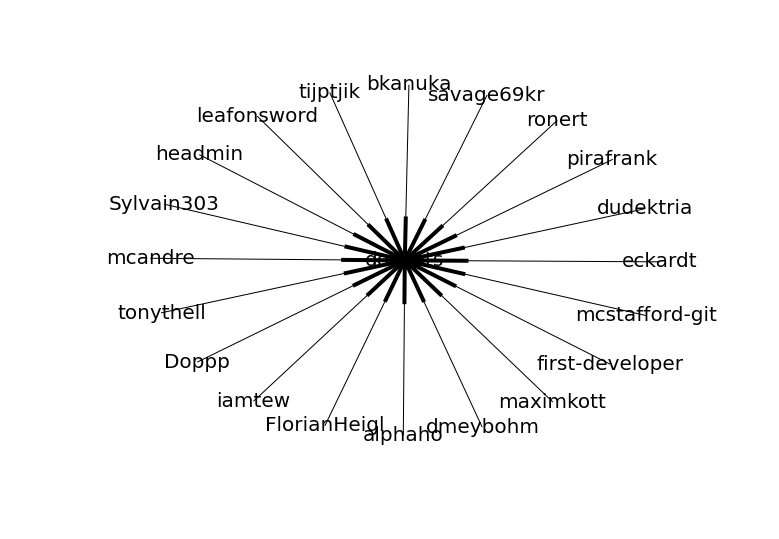

In [135]:
%matplotlib inline
from networkx.drawing import draw_spring
import seaborn as sns
import matplotlib.pyplot as plt

with sns.plotting_context(context="poster"):
    pos=nx.spring_layout(g) # positions for all nodes
    
    elist=[(u,v) for (u,v,d) in g.edges(data=True)]
    

    # nodes
#     nx.draw_networkx_nodes(g,pos, node_cmap=plt.cm.Blues, node_size=0)

    # edges
    nx.draw_networkx_edges(g,pos,width=1)
    
    # labels
    nx.draw_networkx_labels(g,pos, font_size=20,font_family='Helvetica')
    plt.axis('off')

## Using a No-SQL Database

Head to the [MongoDB download page](http://www.mongodb.org/downloads)  and get the latest stable version) for your OS.

#### unzip

Unzip `mongodb-X.tgz` and rename folder `mongodb-X` to simply `mongodb`. I normally move this folder to my personal project folder so feel free to move it in wherever you like. Your mongodb folder should have the following structure:

```bash
GNU-AGPL-3.0        README              THIRD-PARTY-NOTICES bin
mongodb/bin:
bsondump     mongod       mongoexport  mongoimport  mongoperf    mongos       mongostat
mongo        mongodump    mongofiles   mongooplog   mongorestore mongosniff   mongotop
```

#### startserver

```bash
cd mongodb
./bin/mongod --dbpath . --nojournal &
```

In [27]:
# Open another terminal windows and type:

```bash
~/YOURPATH/mongodb/bin/mongo
```

```bash
MongoDB shell version: 2.4.9
connecting to: test
Welcome to the MongoDB shell.
For interactive help, type "help".
For more comprehensive documentation, see
	http://docs.mongodb.org/
Questions? Try the support group
	http://groups.google.com/group/mongodb-user
```

In [138]:
!sudo tail -f /var/log/mongodb/mongod.log

2015-07-04T01:59:43.364+0800 [initandlisten] recover lsn: 0
2015-07-04T01:59:43.364+0800 [initandlisten] recover /var/lib/mongodb/journal/j._0
2015-07-04T01:59:44.354+0800 [initandlisten] recover cleaning up
2015-07-04T01:59:44.355+0800 [initandlisten] removeJournalFiles
2015-07-04T01:59:44.474+0800 [initandlisten] recover done
2015-07-04T01:59:44.474+0800 [initandlisten] preallocating a journal file /var/lib/mongodb/journal/prealloc.0
2015-07-04T01:59:47.520+0800 [initandlisten] 		File Preallocator Progress: 408944640/1073741824	38%
2015-07-04T01:59:50.054+0800 [initandlisten] 		File Preallocator Progress: 576716800/1073741824	53%
2015-07-04T01:59:53.037+0800 [initandlisten] 		File Preallocator Progress: 1038090240/1073741824	96%
2015-07-04T01:59:54.233+0800 [initandlisten] waiting for connections on port 27017
^C

then you are good to go! Type exit to quit!

### PyMongo

PyMongo is a Python distribution containing tools for working with MongoDB, and is the recommended way to work with MongoDB from Python. You can install mongodb from either pip or easy_install.



#### Connecting to MongoDB

In Pymongo 2.4.1 the Connection() method has been deprecated. Now we most use MongoClient

In [ ]:
# !pip install pymongo

In [140]:
import pymongo

# Connection to Mongo DB
try:
    conn=pymongo.MongoClient()
    print "Connected successfully!!!"
except pymongo.errors.ConnectionFailure, e:
   print "Could not connect to MongoDB: %s" % e 
conn

Connected successfully!!!


MongoClient('localhost', 27017)

### Databases

Mongodb creates databases and collections automatically for you if they don't exist already. A single instance of MongoDB can support multiple independent databases. When working with PyMongo you access databases using attribute style access:

In [142]:
db = conn.tweets
db

Database(MongoClient('localhost', 27017), u'tweets')

If your database name is such that using attribute style access won’t work (like db-name), you can use dictionary style access instead:

In [143]:
db = conn['data-science']
db

Database(MongoClient('localhost', 27017), u'data-science')

If you need to know what databases are available:

In [144]:
conn.database_names()

[u'local', u'admin']

We already created 2 new databases. Why didn't show up with the above command? Well, databases with no collections or with empty collections will not show up with database_names(). Same goes when we try to list empty collections in a database.

We'll test it again once we have populate some collections.

### Collections

A collection is a group of documents stored in MongoDB, and can be thought of as roughly the equivalent of a table in a relational database. Getting a collection in PyMongo works the same as getting a database:

In [145]:
collection = db.tweets
collection

Collection(Database(MongoClient('localhost', 27017), u'data-science'), u'tweets')

In [146]:
db.collection_names()

[]

However one must be careful when trying to get existing collections. For example, if you have a collection db.user and you type db.usr this is clearly a mistake. Unlike an RDBMS, MongoDB won't protect you from this class of mistake.

### Documents

MongoDB stores structured data as JSON-like documents, using dynamic schemas (called BSON), rather than predefined schemas. An element of data is called a document, and documents are stored in collections. One collection may have any number of documents.

Compared to relational databases, we could say collections are like tables, and documents are like records. But there is one big difference: every record in a table has the same fields (with, usually, differing values) in the same order, while each document in a collection can have completely different fields from the other documents.

All you really need to know when you're using Python, however, is that documents are Python dictionaries that can have strings as keys and can contain various primitive types (int, float,unicode, datetime) as well as other documents (Python dicts) and arrays (Python lists).

To insert some data into MongoDB, all we need to do is create a dict and call .insert() on the collection object:

In [147]:
doc = {"name":"Alberto","surname":"Negron","twitter":"@Altons"}

Now we need to insert the above document into a collection:

In [148]:
collection.insert(doc)

ObjectId('5596de7dfb1fdb099cb0c7db')

In [149]:
conn.database_names()

[u'local', u'data-science', u'admin']

In [150]:
db.collection_names()

[u'tweets', u'system.indexes']

Congratulations you have created your first document!!

Now `database_names()` and `collection_names()` show database data-science and collection `tweets`.

To recap, we have **databases** containing **collections**. A **collection** is made up of **documents**. Each document is made up of **fields**.

## Using Twitter API

In [45]:
# !pip install tweepy

Follow the [authentication tutorial](http://docs.tweepy.org/en/v3.2.0/auth_tutorial.html#auth-tutorial)

[Get Twitter API Key](https://apps.twitter.com/app/new)

Be sure to allow your app to also havewrite access.

In [151]:
import tweepy
from tweepy import API

In [152]:
consumer_key = '1tC8FNuMiVfFa4PvcuizVI2NF'
consumer_secret = 'eDrVwrlkl3Qr6F8DaNOhuyOYlt7lSZeifDPo4w3nvi56TPaMPc'

In [153]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

In [154]:
auth_url = auth.get_authorization_url()
print 'Please authorize: ' + auth_url

Please authorize: https://api.twitter.com/oauth/authorize?oauth_token=WgiXrAAAAAAAe70QAAABTlVVVoQ


In [155]:
PASTE_YOUR_PIN = '7710694'
auth.get_access_token(PASTE_YOUR_PIN)

(u'69573308-Djl4EcKPcu2H8SwuvqAPjrW7ARhZEdvU7TVArUl4n',
 u'lcFUEQ3p3zbeQHiXuPnPRsRQm8bFN31q4iAHSyeZiU7EH')

In [157]:
print "ACCESS_KEY =" , auth.access_token

ACCESS_KEY = 69573308-Djl4EcKPcu2H8SwuvqAPjrW7ARhZEdvU7TVArUl4n


In [158]:
print 'ACCESS_SECRET =', auth.access_token_secret

ACCESS_SECRET = lcFUEQ3p3zbeQHiXuPnPRsRQm8bFN31q4iAHSyeZiU7EH


In [184]:
# access_token = '69573308-BJpz769nKioxfcySpvEBNK7ebU3uS6TuDkMZ6VyBP'
# access_token_secret = 'bCFmnvs3QX5HmoE8oTwUHpjE2QIE8xKFRwb06pg2fksJ8'
# auth.set_access_token(access_token, access_token_secret)

# If you want to parse continue using the Tweepy object use
# api = tweepy.API(auth)
# If you just want to pretty print use
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [185]:
msg = 'Teaching the Twitter API while MongoDB silently weeps.'
response = api.update_status(status=msg)

In [186]:
import pprint
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(response)

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Fri Jul 03 19:21:54 +0000 2015',
 u'entities': {u'hashtags': [],
               u'symbols': [],
               u'urls': [],
               u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': None,
 u'id': 617050651252518912,
 u'id_str': u'617050651252518912',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',
 u'place': None,
 u'retweet_count': 0,
 u'retweeted': False,
 u'source': u'<a href="https://localhost.local" rel="nofollow">Data Science 5</a>',
 u'text': u'Teaching the Twitter API while MongoDB silently weeps.',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
           u'created_at': u'Fri Aug 28 12:18:01 +0000 2009',
           u'default_profile': False,
           u'default_profile_image': False,
           u

In [ ]:
# If you still have the Twepy Object you can now favorite your  tweet!
response.favorite()

### Public tweets

In [188]:
api = tweepy.API(auth)
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print tweet.user.name, ':', tweet.text, '\n'

Mart van de Ven : Teaching the Twitter API while MongoDB silently weeps. 

Mart van de Ven : Teaching the Twitter API while MongoDB silently weeps... again II 

HeatherLeson : Paper carnage  #smdayqr starring @setarehraeisi awesome shoes http://t.co/EoitLJB6JH 

HeatherLeson : Around the room #SMDayQR http://t.co/fUdB9uNldc 

HeatherLeson : RT @meddyco: Making your own timeline #smdayqr http://t.co/eeLRf8pR1D 

HeatherLeson : Awesome creative buzz #SMDayQR http://t.co/EdB4VSsAUe 

HeatherLeson : What! Too busy making crafts about social streams to tweet #SMDayQR http://t.co/ejKJQVIwYc 

Open Science : RT @OCSDNet: #OCSDNet members ask: What is the role of #OpenScience in the upcoming #SDG’s? So far unclear, despite key implications for #d… 

HeatherLeson : Happy to introduce @ingmarweber and @haghadi - innovators in health research in #qatar @QatarComputing #SMDayqr http://t.co/CHHK9r4u2H 

HeatherLeson : Kicking off #smdayqr with @iloveqatar - sharing Ramadan sharing online #doha http

### Searching for a Term

In [190]:
tweepy.__version__

'3.3.0'

In [201]:
lookup = 'BigData'

for status in tweepy.Cursor(api.search, q=lookup).items(10):
    # process status here
    print status.text, '\n'

RT @DiegoKuonen: "In God we trust, all others must bring data."

W. Edwards Deming &lt; http://t.co/HFiQ0lFOrg

#Data #AnyData #BigData #IoT 

RT @DiegoKuonen: "In God we trust, all others must bring data."

W. Edwards Deming &lt; http://t.co/HFiQ0lFOrg

#Data #AnyData #BigData #IoT 

@dhaijtema @MTnieuws @Efteling complimenten voor deze uitgave! Mooie inspirerende verhalen en veel leuke info over #BigData 

Is BigData A Costly Gamble? http://t.co/u5oTraqazq 

Feel better, monetize your med data @portablegenomic, interview FR @Billaut Fair trade #BigData in #health @IBMWatson http://t.co/AtGkix50Lf 

RT @andrewsmith1443: Mid-Year Roundup: #BigData,  Predictive Capabilities Key Themes In #B2B Landscape http://t.co/NH9UJFspWT http://t.co/U… 

RT @KirkDBorne: Bonanza of #DataScience Venn Diagrams: http://t.co/nmG0ij1mxu #abdsc #BigData  #Statistics #MachineLearning http://t.co/yEW… 

RT @IBMcloud: A must-read for CMOs: How to make and measure success with #cloud and #bigdata. http://t.co/

In [207]:
results = tweepy.Cursor(api.search, q=lookup)
results?

In [208]:
items = tweepy.Cursor(api.search, q=lookup).items(1)
items?

### What can we play with?

In [211]:
for status in tweepy.Cursor(api.search, q=lookup).items(1):
    pp.pprint([fn for fn in dir(status) if '_' is not fn[0]])

['author',
 'contributors',
 'coordinates',
 'created_at',
 'destroy',
 'entities',
 'favorite',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'metadata',
 'parse',
 'parse_list',
 'place',
 'possibly_sensitive',
 'retweet',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'retweets',
 'source',
 'source_url',
 'text',
 'truncated',
 'user']


### Challenge : Build up your own dataset

* Search twitter for a specific term, and build up a dataset for it.
* Store the following columns:
    * `created_at`
    * `from_user`
    * `from_user_id`
    * `from_user_id_str`
    * `from_user_name`
    * `geo`
    * `id`
    * `iso_language_code`
    * `source`
    * `text`
    * `to_user`
    * `to_user_id`
    * `to_user_id_str`
    * `to_user_name`
* What serialisation format would you use for this data?
* Try to index by `created_at`
* Change the index to the `datetime` type
* Can you do some simple factor analysis based on some of the categorical features?
* Write a word count function which counts how often  words show up in tweets about your term.
* What are the 10 most popular terms?

### Challenge : Writing your dataset to MongoDB

There is a lot of information that we really don't need. Let's keep only the data related to the tweet and insert it into MongoDB

In [212]:
# Define my mongoDB database
db = conn.twitter_results
# Define my collection where I'll insert my search
posts = db.posts

In [213]:
# loop through search and insert dictionary into mongoDB
for tweet in search:
    # Empty dictionary for storing tweet related data
    data ={}
    
    # ADD YOUR DATA STRUCTURE HERE    
    
    # Insert process
    posts.insert(data)

NameError: name 'search' is not defined

#### The _id field

In MongoDB, documents stored in a collection require a unique _id field that acts as a primary key. Because ObjectIds are small, most likely unique, and fast to generate, MongoDB uses ObjectIds as the default value for the _id field if the _id field is not specified; i.e., the mongod adds the _id field and generates a unique ObjectId to assign as its value

#### Reading Documents in a Collection

The first and foremost important operation we need to learn is how to retrieve our data from MongoDB. For this, Collections provide the find_one() and find() methods:

The find_one() method selects and returns a single document from a collection and returns that document (or None if there are no matches). It is useful when you know there is only one matching document, or are only interested in the first match:

In [ ]:
posts.find_one()

To get more than a single document as the result of a query we use the find() method. find() returns a Cursor instance, which allows us to iterate over all matching documents.

In [ ]:
posts.find()

For example, we can iterate over the first 2 documents (there are a lot in the collection and this is just an example) in the posts collection:

In [ ]:
for d in posts.find()[:2]:
    print d

you can also use the standard python list():

In [ ]:
list(posts.find())[:2]

#### Counting

If we just want to know how many documents match a query we can perform a count() operation instead of a full query. We can get a count of all of the documents in a collection:

In [ ]:
posts.count()

#### Query Operators

MongoDB queries are represented as JSON-like structure, just like documents. To build a query, you just need to specify a dictionary with the properties you wish the results to match. For example, this query will match all documents in the posts collection with ISO language code "en".

In [ ]:
posts.find({"iso_language_code": "en"}).count()

If we wanted to retrieve all documents with ISO language code "en" and source equal to "twitterfeed":

In [ ]:
posts.find({"iso_language_code":"en","source":"twitterfeed"}).count()

Queries can also use special query operators. These operators include gt, gte, lt, lte, ne, nin, regex, exists, not, or, and many more. The following queries show the use of some of these operators.

In [ ]:
from datetime import datetime
# cheat: year, month, day, hour, minute, second, microsecond
date1 = datetime.strptime("18/03/15 18:30", "%d/%m/%y %H:%M")
date2 = datetime.strptime("18/03/13 18:05", "%d/%m/%y %H:%M")
date3 = datetime.strptime("18/03/15 18:10", "%d/%m/%y %H:%M")
date4 = datetime.strptime("18/03/15 18:25", "%d/%m/%y %H:%M")

cursor = posts.find({'created_at':{"$gt":date1}})
cursor.next()

This time we will do the same query but add the count() method to only get the count of documents that match the query. We will use count() from now onwards (easier!!!)

In [ ]:
posts.find({'created_at':{"$gt":date1}}).count()

In [ ]:
# Tweets dates low than or equal to date2
posts.find({'created_at':{"$lte":date2}}).count()

In [ ]:
# Between 2 dates
posts.find({"created_at": {"$gte": date3, "$lt": date4}}).count()

In [ ]:
# Posts in either spanish or french using $or
posts.find({"$or":[{"iso_language_code":"es"},{"iso_language_code":"fr"}]}).count()

In [ ]:
# All posts except spanish or french
posts.find({"iso_language_code":{"$nin":["es","fr"]}}).count()

In [ ]:
# Using Regex to find a post with hashtag #analytics
import re
regex = re.compile(r'#analytics')
rstats = posts.find_one({"text":regex})
rstats

### Challenge : Reading your dataset to MongoDB

* Play around with queries to become comfortable with the syntax, 
* If `posts.find().sort([("created_at", pymongo.ASCENDING)])` would 
give you a sorted collection based on 'created_at' field, how would you get the latest 10 tweets?
* Write a function which retrieves all the tweets which contain words any of the top 10 most common words

## Tying is all together : Blaze

[Review Code](http://continuum.io/blog/blaze-expressions)

## Reference

* [NOSQL DATA MODELING TECHNIQUES](https://highlyscalable.wordpress.com/2012/03/01/nosql-data-modeling-techniques/)
* [Simple CSV Data Wrangling with Python](https://districtdatalabs.silvrback.com/simple-csv-data-wrangling-with-python)
* [A Python guide for open data file formats](http://opendata.stackexchange.com/questions/1208/a-python-guide-for-open-data-file-formats)
* [Dive into Python 3 : XML](http://www.diveintopython3.net/xml.html)
*  [Gentle Introduction to MongoDB using Pymongo](http://altons.github.io/python/2013/01/21/gentle-introduction-to-mongodb-using-pymongo/)